# Utilisation du modèle SARIMA pour prédire la consommation Electrique¶

- Granularité : jours / mois
- Valeur Exogène : Oui - (Météo) :
    - rafales_sur_une_periode, 
    - variation_de_pression_en_3_heures,
    - precipitations_dans_les_3_dernieres_heures', 
    - pression_station,
    - pression_au_niveau_mer', 
    - direction_du_vent_moyen,
    - vitesse_du_vent_moyen, 
    - humidite, 
    - point_de_rosee, 
    - temperature_c

In [1]:
#importation des packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import itertools
warnings.filterwarnings("ignore")
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
#lecture des données et pre cleaning
df = pd.read_csv('clean_data/data_meteo_prod.csv', header=0, parse_dates=[0],  index_col=14,squeeze=True)
df['rafales_sur_une_periode']=df['rafales_sur_une_periode'].astype(float)
colonne_inutile =['regioncode', 'latitude', 'longitude', 'altitude',
                  'thermique_mw', 'nucleaire_mw', 'eolien_mw', 'solaire_mw',
                  'hydraulique_mw', 'pompage_mw', 'bioenergies_mw', 'ech._physiques_mw',
                  'prod_totale']
df= df.drop(colonne_inutile, axis=1)
df.index= pd.to_datetime(df.index)

## Prédiction par mois 

### SARIMAX 

Aggrégation des valeurs du dataset par mois :

In [3]:
function_to_apply = {
    'rafales_sur_une_periode' : 'max',
    'variation_de_pression_en_3_heures' : 'sum',
    'precipitations_dans_les_3_dernieres_heures' : 'sum',
    'pression_station' : 'mean',
    'pression_au_niveau_mer' : 'mean',
    'direction_du_vent_moyen' : 'median', #médiane de la direction sur la journée
    'vitesse_du_vent_moyen' : 'mean',
    'humidite' : 'mean',
    'point_de_rosee' : 'mean',
    'temperature_c' : 'mean',
    'consommation_mw' : 'sum',
}
df_sarima = df.resample('M').agg(function_to_apply)

In [4]:
data = df_sarima['consommation_mw'].loc['2013-01-01':'2019-12-31']
exogene = df_sarima.drop('consommation_mw', axis=1).loc['2013-01-01':'2019-12-31']

## Recherche des meilleurs paramètres : 

*NB : La saisonnalité (période 12) a été déterminé via des graphs de différenciation dans les notebooks précédents.*

In [5]:
import warnings
warnings.filterwarnings('ignore')
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
params_results = {}
print("Calcul en cours...")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            exog =exogene
                                            )
            results = mod.fit()
            params_results['ARIMA{}x{}12'.format(param, param_seasonal)] = round(results.aic, 0)
        except:
            continue
best_params = min(params_results, key=params_results.get)

print(best_params, 'AIC :', params_results[best_params])
print("Calcul terminé.")


Calcul en cours...
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 AIC : 2342.0
Calcul terminé.


In [6]:
model=sm.tsa.SARIMAX(data ,exog =exogene ,order=(0,1,0) ,seasonal_order = (0, 1, 1, 12))
sarima=model.fit()
print(sarima.summary().tables[1])

                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
rafales_sur_une_periode                     1.331e+04   2.82e+04      0.472      0.637   -4.19e+04    6.86e+04
variation_de_pression_en_3_heures              6.4980      3.303      1.967      0.049       0.024      12.972
precipitations_dans_les_3_dernieres_heures -1570.7041    429.611     -3.656      0.000   -2412.726    -728.683
pression_station                             -6.4e+04   1.76e+04     -3.627      0.000   -9.86e+04   -2.94e+04
pression_au_niveau_mer                      6.089e+04   1.82e+04      3.348      0.001    2.52e+04    9.65e+04
direction_du_vent_moyen                     -1.24e+04   6803.832     -1.823      0.068   -2.57e+04     931.922
vitesse_du_vent_moyen                       3.769e+05   6.67e+05      0.565      0.572    -9.3e+05    1.68e+06
h

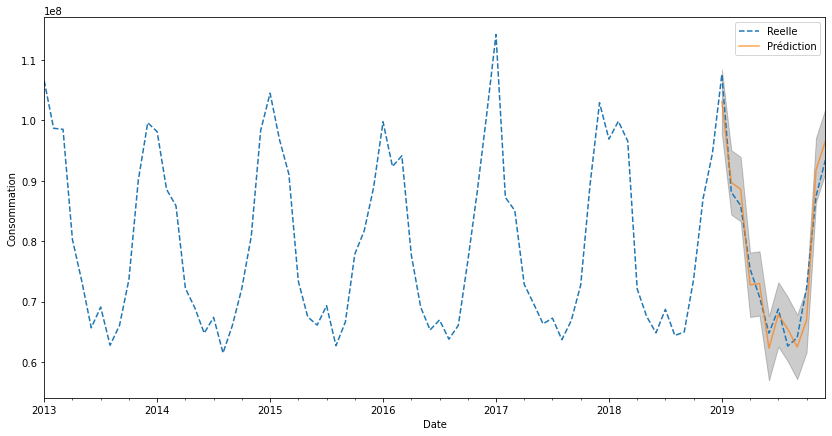

In [7]:
pred = sarima.get_prediction(start=pd.to_datetime('2019-01-31'), dynamic=False)
pred_ci = pred.conf_int()

ax = data['2013':].plot(label='Reelle', style='--')
pred.predicted_mean.plot(ax=ax, label='Prédiction', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Consommation')
plt.legend()
plt.show()

### Future

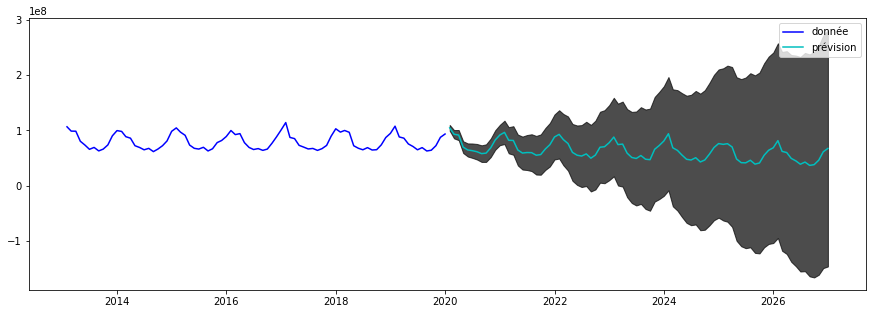

In [8]:
prediction = sarima.get_forecast(steps =84, exog=exogene).summary_frame()  #Prédiction avec intervalle de confiance

fig, ax = plt.subplots(figsize = (15,5))
predm = prediction['mean']

plt.plot(data, label='donnée', color ='b')
plt.plot(predm ,label='prévision', color='c') #Visualisation de la moyenne
plt.legend();

ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.7); #Visualisation de l'intervalle de confiance


# Détermination de la Saisonnalité par jours

- sans valeur exo

Nous nous contenterons des données de 2018 - 2019

In [29]:
function_to_apply = {
    'rafales_sur_une_periode' : 'max',
    'variation_de_pression_en_3_heures' : 'sum',
    'precipitations_dans_les_3_dernieres_heures' : 'sum',
    'pression_station' : 'mean',
    'pression_au_niveau_mer' : 'mean',
    'direction_du_vent_moyen' : 'median', #médiane de la direction sur la journée
    'vitesse_du_vent_moyen' : 'mean',
    'humidite' : 'mean',
    'point_de_rosee' : 'mean',
    'temperature_c' : 'mean',
    'consommation_mw' : 'sum',
}
df_day = df.resample('D').agg(function_to_apply)
df_day = df_day.loc['2018':]

data = df_day['consommation_mw'].loc['2018-01-01':'2019-12-31']
exogene = df_day.drop('consommation_mw', axis=1).loc['2018-01-01':'2019-12-31']

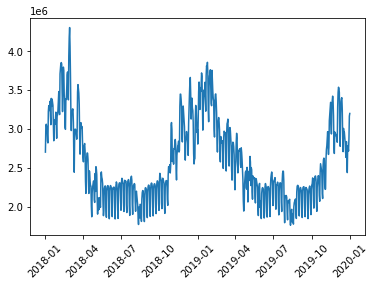

In [30]:
plt.plot(data)
plt.xticks(rotation=45)
plt.show()

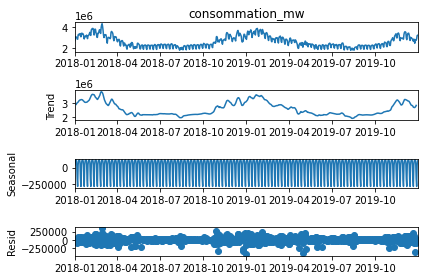

In [31]:
res = seasonal_decompose(data, period = 7, model='additive')
res.plot()
plt.show()

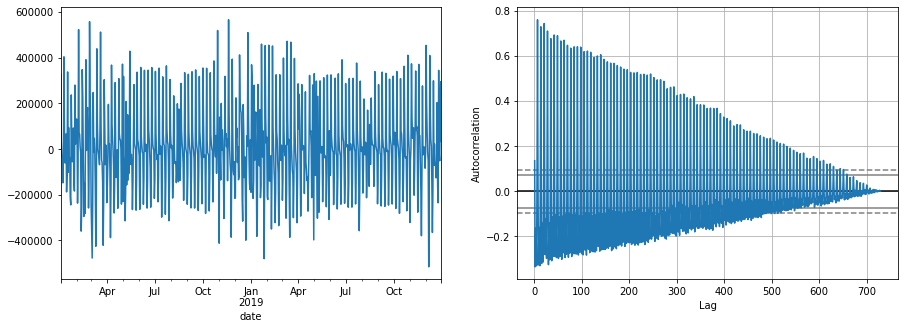

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5)) # Création de la figure et des axes

data_1 = data.diff().dropna() # Différenciation ordre 1

data_1.plot(ax = ax1) #Série temporelle différenciée

pd.plotting.autocorrelation_plot(data_1, ax = ax2); #Autocorrélogramme de la série différenciée

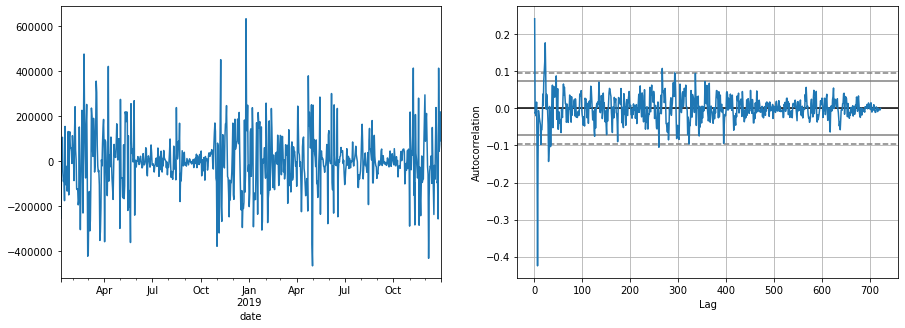

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5)) # Création de la figure et des axes

data_2 = data_1.diff(7).dropna() # Différenciation ordre 7

data_2.plot(ax = ax1) #Série temporelle différenciée

pd.plotting.autocorrelation_plot(data_2, ax = ax2); #Autocorrélogramme de la série différenciée